# **CRASH ANALYTICS FOR MONTGOMERY COUNTY**

**Project** 
>The primary goal of this project is to conduct a comprehensive analysis of traffic crash data across Montgomery County from 2015 to 2023. By examining monthly trends over these years, we aim to provide the UMD community and the general public with insights into the most prevalent types of traffic incidents, as well as the locations and times they most frequently occur. 

>Throughout this tutorial, we will explore potential correlations between the types of crashes and their specific locations, the frequency of these incidents at different hours, and how these patterns might vary with the seasons. Our objective is to uncover meaningful trends that can inform safety improvements and awareness initiatives within the community.

**Required Tools**
You will need to install the following librairies for this project:
- pandas
- numpy
- matplotlib
- seaborn
- scikit-learn
- scipy

In [36]:
%pip install -q pandas
%pip install -q numpy
%pip install -q matplotlib
%pip install -q seaborn
%pip install -q scikit-learn
%pip install -q scipy
%pip install -q statsmodels

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

# **Dataset Collection & Preprocessing**

**1. DATA COLLECTION:**

This is the initial stage of our data lifecycle, focusing on the systematic collection of data from established datasets or various files.

In this project, we sourced our data directly from the Montgomery County Government's open data portal. The specific dataset used, titled "Crash Reporting Incidents Data," is available for direct download at [https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Incidents-Data/bhju-22kf/about_data](https://data.montgomerycountymd.gov/Public-Safety/Crash-Reporting-Incidents-Data/bhju-22kf/about_data). This comprehensive dataset contains detailed records of traffic incidents reported in Montgomery County, which serves as a foundational element for our analysis.

For managing and manipulating the downloaded CSV file, we utilized the following tools:

- `pandas`: for robust data manipulation and analysis.
- `numpy`: for high-level mathematical functions and operations on arrays.
- `datetime`: for handling date and time data.
- `os.path`: for managing file paths.

Our process involves downloading the CSV file directly from the provided link, which ensures that we have the complete and up-to-date dataset. We then load this data into a pandas DataFrame, enabling us to perform detailed analyses and manipulations as required by our project’s objectives.

Below, we will detail the steps involved in processing the data to demonstrate how we prepare and analyze the data for our needs.

In [ ]:
crash_df = pd.read_csv('Crash_Report.csv')
crash_df

In [ ]:
rows, cols = crash_df.shape
print("Rows: " + str(rows) + "\n" + "Columns: " + str(cols))

In [ ]:
for col_names in crash_df.columns:
  print(col_names)

In [35]:
# Find the earliest date
earliest_date = crash_df['Crash Date/Time'].min()

# Find the latest date
latest_date = crash_df['Crash Date/Time'].max()

# Print the results
print("Earliest crash date:", earliest_date)
print("Latest crash date:", latest_date)

Earliest crash date: 01/01/2015 01:10:00 AM
Latest crash date: 12/31/2023 12:19:00 AM


**2. DATA PREPROCESSING:**

This phase is crucial for preparing the raw data into a format suitable for analysis. Given the extensive nature of the dataset and our specific research objectives, we adopted a selective approach to data preprocessing to ensure efficiency and relevance in our analysis.

### Column Selection:
Initially, we identified and retained only the most pertinent columns from the complete dataset. This was done to reduce computational load and focus on the data most relevant to our research questions. The selected columns include identifiers like 'Report Number' and 'Local Case Number', details about the crash such as 'Crash Date/Time', 'Collision Type', and environmental conditions like 'Weather' and 'Light'. 

### Data Cleaning:
The following steps were taken to clean and prepare the data:

- **Conversion to Suitable Data Types**: We converted the 'Crash Date/Time' column into a datetime format, allowing us to extract and analyze the date and time separately.
- **Handling Missing Values**: We filled missing values in categorical columns like 'Hit/Run' and 'Route Type' with the most frequent values or categorized them as 'Unknown'. Numeric fields such as 'Mile Point' were filled using median values to maintain data integrity.
- **Imputation Techniques**: For more complex fields like 'Traffic Control' and 'Light', where data might depend on other factors such as 'Road Name' or the time of the crash, we used group-specific modes and conditional imputation. This approach helps maintain logical consistency across related data fields.
- **Normalization and Error Correction**: We also addressed duplicates and corrected erroneous entries to ensure the uniqueness and accuracy of our data records.

### Enhancing Data Quality:
To further enhance the quality of our dataset, we employed several strategies:
- **Mode Imputation for Categorical Data**: We imputed missing values in 'Weather' and 'Collision Type' using the most common values conditioned on related attributes, ensuring that our data reflects realistic and probable scenarios.
- **Custom Functions for Data Imputation**: For attributes like 'Traffic Control' and 'Light', custom functions were developed to impute values based on the derived rules from the data itself. This method provided a nuanced approach to handling missing data, particularly in cases where simple imputation might not suffice.

### Final Dataset Preparation:
After these steps, the dataset was transformed into a cleaner, more manageable format, making it ready for the subsequent stages of data analysis and visualization. The focus on careful preprocessing ensures that our findings are based on accurate and representative data, thereby enhancing the reliability of our conclusions.

In [ ]:
'''
For the sake of precise analysis and considering the large file size,
we are only considering columns that seem essential to our analysis,
whilst striping the rest.

If this is not possible, our team would be happy to fix this and consider the
entire dataset.
'''
columns_to_keep = [
    'Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
    'Crash Date/Time', 'Hit/Run', 'Route Type', 'Mile Point', 'Lane Direction',
    'Lane Number', 'Number of Lanes', 'Direction', 'Road Name', 'Cross-Street Name',
    'At Fault', 'Collision Type', 'Weather', 'Surface Condition', 'Light', 'Traffic Control', 'Latitude', 'Longitude', 'At Fault'
]

filtered_df = crash_df[columns_to_keep]
filtered_df

In [ ]:
filtered_df.dtypes

In [ ]:
info = filtered_df.count()
info

In [ ]:
null_counts_corrected = filtered_df.isnull().sum()
null_counts_corrected

This indicates there are numerous null values in multiple columns.

In [ ]:
print(filtered_df.duplicated().sum())

In [ ]:
filtered_df['Crash Date/Time'] = pd.to_datetime(filtered_df['Crash Date/Time'])
filtered_df['Crash Date'] = filtered_df['Crash Date/Time'].dt.date
filtered_df['Crash Time'] = filtered_df['Crash Date/Time'].dt.time
filtered_df

Convertng dates to ISO format, further making dates and times into two different columns.

In [ ]:
hit_run_mode = filtered_df['Hit/Run'].mode()[0]
filtered_df['Hit/Run'] = filtered_df['Hit/Run'].fillna(hit_run_mode)
na_hit = filtered_df[filtered_df['Hit/Run'].isna()]
na_hit

Imputated the Hit/Run Column as it consisted of two N/A values. The above shows that the N/A values for the Hit/Run Column do not exist anymore.

In [ ]:
filtered_df['Route Type'] = filtered_df['Route Type'].fillna('Unknown')
filtered_df['Route Type'].value_counts()

In [ ]:
mile_point_median = filtered_df['Mile Point'].median()
print("The median for Mile Point's data is: " + str(mile_point_median))
filtered_df['Mile Point'] = filtered_df['Mile Point'].fillna(mile_point_median)
filtered_df

Using the median to impute missing values in "Mile Point" for robustness against skewed data and outliers.

In [ ]:
for i in ['Lane Direction', 'Road Name', 'Cross-Street Name', 'Route Type', 'Direction', 'Surface Condition']:
  filtered_df[i] = filtered_df[i].fillna('Unknown')

filtered_df

Since "Lane Direction" indicates the direction of the lane in which the incident occurred, I recognize it as a significant piece of information that can affect the understanding of each crash's context. However, without a clear way to deduce the missing directions from other data (unless there's a discernible pattern or correlation with other variables), my safest approach would be to impute these missing values with a placeholder value such as "Unknown". This method acknowledges the missing data without making assumptions that could introduce bias into my analysis.

In [ ]:
import numpy as np
traffic_control_mapping = filtered_df.groupby('Road Name')['Traffic Control'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()

def impute_traffic_control(row):
    if pd.isna(row['Traffic Control']) and row['Road Name'] in traffic_control_mapping:
        return traffic_control_mapping[row['Road Name']]
    else:
        return row['Traffic Control']

filtered_df['Traffic Control'] = filtered_df.apply(impute_traffic_control, axis=1)

filtered_df['Traffic Control'] = filtered_df['Traffic Control'].fillna('Unknown')

filtered_df

In [ ]:
import datetime

def impute_light_condition(row):
    if pd.isna(row['Light']):
        crash_time = row['Crash Time']

        daylight_start = datetime.time(6, 0)
        daylight_end = datetime.time(18, 0)
        dusk_end = datetime.time(19, 0)
        dawn_start = datetime.time(5, 0)

        if daylight_start <= crash_time <= daylight_end:
            return 'DAYLIGHT'
        elif daylight_end < crash_time <= dusk_end:
            return 'DUSK'
        elif dawn_start <= crash_time < daylight_start:
            return 'DAWN'
        else:

            return 'DARK -- UNKNOWN LIGHTING'

    else:
        return row['Light']


if not isinstance(filtered_df['Crash Time'].iloc[0], datetime.time):
    filtered_df['Crash Time'] = pd.to_datetime(filtered_df['Crash Time'], format='%H:%M:%S').dt.time

filtered_df['Light'] = filtered_df.apply(impute_light_condition, axis=1)
filtered_df

This code first checks if the "Light" column is missing a value for a given row. If it is, it then determines the light condition based on the "Crash Time" compared to predefined time ranges that represent daylight, dusk, and dawn. For times outside of these ranges, it defaults to "DARK -- UNKNOWN LIGHTING" to reflect a conservative approach during nighttime hours. This method helps to fill in missing data with reasoned assumptions while minimizing potential biases that could arise from more arbitrary imputations.

In [ ]:
weather_mode = filtered_df['Weather'].mode()[0]
filtered_df['Weather'] = filtered_df['Weather'].fillna(weather_mode)

filtered_df

In [ ]:
collision_type_by_weather = filtered_df.groupby('Weather')['Collision Type'].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan).to_dict()

def impute_collision_type(row):
    if pd.isna(row['Collision Type']):
        return collision_type_by_weather.get(row['Weather'], np.nan)
    else:
        return row['Collision Type']

filtered_df['Collision Type'] = filtered_df.apply(impute_collision_type, axis=1)

filtered_df['Collision Type'] = filtered_df['Collision Type'].fillna('Unknown')

The code determines the most common "Collision Type" for each "Weather" condition by grouping the data by "Weather" and calculating the mode of "Collision Type" within each group. This mapping of "Weather" conditions to the most frequent "Collision Type" is stored as a dictionary. Next, the user defines a function that checks if "Collision Type" is missing for a row; if it is, the function attempts to impute the missing value using the "Weather"-to-"Collision Type" mapping. This function is applied to each row of the DataFrame. If "Collision Type" is missing and the row's "Weather" is found in the mapping, the missing "Collision Type" is imputed with the most common type associated with that weather condition. In the end, if still Collision types are missing then they are replaced with the "Unkown" tag to remove bias from the table.

In [ ]:
null_counts_corrected = filtered_df.isnull().sum()
print(null_counts_corrected)
print("No Cases with NULL values left! -> Data is somewhat cleansed :)")

--------------------------------------------------------------------------------

# **Data Exploration and Summary Statistics**

# **1.   Hypothesis: Light(Headlights) Conditions and Hit/Run Incidents**

*Null Hypothesis (H0): The proportion of hit/run incidents is the same during daylight and dark conditions.*

*Alternative Hypothesis (H1): The proportion of hit/run incidents during daylight is different from that during dark conditions.*

*Test to Use: A Z-test for two proportions would be appropriate if you have a large sample size, which is likely given that this is traffic incident data. This test will compare the proportion of hit/run incidents in daylight vs. dark conditions.*

In [ ]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

crash_data = filtered_df.copy()
crash_data.loc[:, 'Hit_Run_Binary'] = (crash_data['Hit/Run'] == 'Yes').astype(int)

dark_condition_values = ['DARK LIGHTS ON', 'DARK NO LIGHTS', 'DUSK', 'DAWN', 'DARK -- UNKNOWN LIGHTING']

daylight_hitrun_count = crash_data.loc[crash_data['Light'] == 'DAYLIGHT', 'Hit_Run_Binary'].sum()
dark_hitrun_count = crash_data.loc[crash_data['Light'].isin(dark_condition_values), 'Hit_Run_Binary'].sum()

daylight_count = (crash_data['Light'] == 'DAYLIGHT').sum()
dark_count = crash_data['Light'].isin(dark_condition_values).sum()

if daylight_count > 0 and dark_count > 0:
    counts = np.array([daylight_hitrun_count, dark_hitrun_count])
    nobs = np.array([daylight_count, dark_count])
    stat, pval = proportions_ztest(counts, nobs)
else:
    stat, pval = None, None

print(f"Daylight Hit/Run Count: {daylight_hitrun_count}")
print(f"Dark Hit/Run Count: {dark_hitrun_count}")
print(f"Total Incidents in Daylight Conditions: {daylight_count}")
print(f"Total Incidents in Dark Conditions: {dark_count}")
print(f"Z-test Statistic: {stat}")
print(f"P-value: {pval}")
print("\n")
alpha = 0.05
if pval is not None:
    if pval < alpha:
        print("Reject the null hypothesis. The proportion of hit-and-run incidents is significantly different between daylight and dark conditions.")
    else:
        print("Fail to reject the null hypothesis. There is not enough evidence to conclude that the proportion of hit-and-run incidents is significantly different between daylight and dark conditions.")
else:
    print("Unable to perform the hypothesis test due to insufficient data.")

### **Conclusion**

The negative Z-test statistic indicates that the proportion of hit/run incidents in daylight conditions is lower than in dark conditions, and the extremely small p-value suggests that the difference is statistically significant. This means we reject the null hypothesis and accept the alternative hypothesis that the proportion of hit/run incidents during daylight is different from that during dark conditions.

## **Graph**

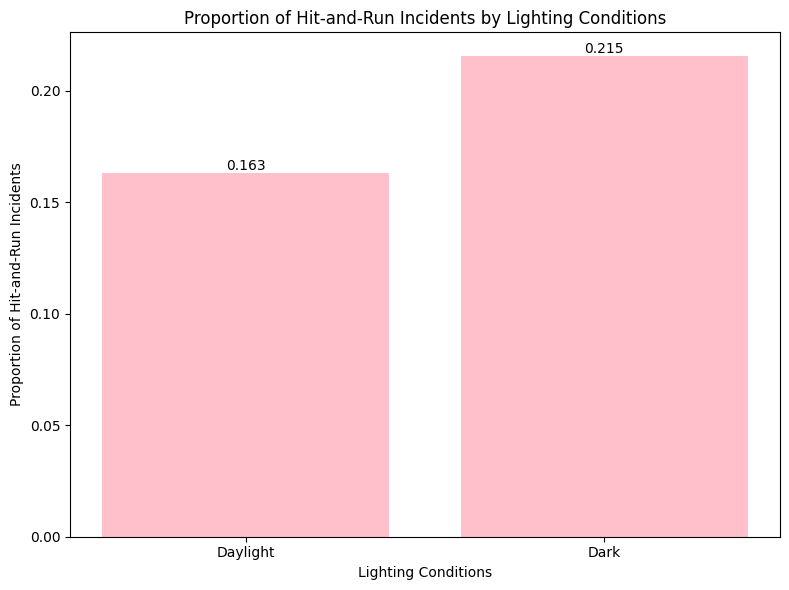

In [ ]:
import matplotlib.pyplot as plt

daylight_proportion = daylight_hitrun_count / daylight_count
dark_proportion = dark_hitrun_count / dark_count

conditions = ['Daylight', 'Dark']
proportions = [daylight_proportion, dark_proportion]

plt.figure(figsize=(8, 6))
plt.bar(conditions, proportions, color = 'pink')
plt.xlabel('Lighting Conditions')
plt.ylabel('Proportion of Hit-and-Run Incidents')
plt.title('Proportion of Hit-and-Run Incidents by Lighting Conditions')

for i, proportion in enumerate(proportions):
    plt.text(i, proportion, f'{proportion:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# **2.   Hypothesis: Weather Conditions and Crash Incidents**

*Null Hypothesis (H0)*: There is no significant difference in the number of crash incidents during clear weather conditions and during adverse weather conditions (e.g., rain, snow, fog).

⁠*Alternative Hypothesis (H1)*: There is a significant difference in the number of crash incidents between clear weather conditions and adverse weather conditions.

*Test to Use*: We use a chi-square test if we categorize days as either having clear or adverse weather and count the number of crash incidents on such days. For continuous data (e.g., number of incidents), a t-test could be applicable, for the data distribution.



In [37]:
def categorize_weather(condition):
    if condition == 'CLEAR':
        return 'clear'
    elif condition in ['UNKNOWN', 'OTHER']:
        return 'exclude'
    else:
        return 'adverse'


filtered_df = filtered_df.copy()
filtered_df['Weather_Condition'] = filtered_df['Weather'].apply(categorize_weather)


df_test2 = filtered_df[filtered_df['Weather_Condition'] != 'exclude']
incident_counts_clear = df_test2[df_test2['Weather_Condition'] == 'clear'].groupby('Crash Date/Time').size()
incident_counts_adverse = df_test2[df_test2['Weather_Condition'] == 'adverse'].groupby('Crash Date/Time').size()

print(f"incident_counts_clear: {incident_counts_clear.count()}, incident_counts_adverse: {incident_counts_adverse.count()}")
print("\n")

t_stat, p_val = ttest_ind(incident_counts_clear, incident_counts_adverse, equal_var=False, nan_policy='omit')


print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")


alpha = 0.05
if p_val is not None:
    if p_val < alpha:
        print("Reject the null hypothesis. The proportion of hit-and-run incidents is significantly different between daylight and dark conditions.")
    else:
        print("Fail to reject the null hypothesis. There is not enough evidence to conclude that the proportion of hit-and-run incidents is significantly different between daylight and dark conditions.")
else:
    print("Unable to perform the hypothesis test due to insufficient data.")

print("\n")

incident_counts_clear: 71915, incident_counts_adverse: 22693


T-statistic: 1.7106789081681824
P-value: 0.08714832492139055
Fail to reject the null hypothesis. There is not enough evidence to conclude that the proportion of hit-and-run incidents is significantly different between daylight and dark conditions.




### **Conclusion**

*  Based on the provided P-value of approximately 0.087, we would fail to reject the null hypothesis at a significance level of 0.05. This suggests that there is insufficient evidence to conclude a significant correlation between weather conditions and the number of crash incidents.

*  However, it's important to note that the P-value is close to the significance threshold, indicating a marginal level of significance. Therefore, while we do not have strong evidence to support a correlation between weather conditions and crash incidents, further investigation with a larger dataset or alternative analytical approaches may be warranted to confirm this finding conclusively.





## **Graph**

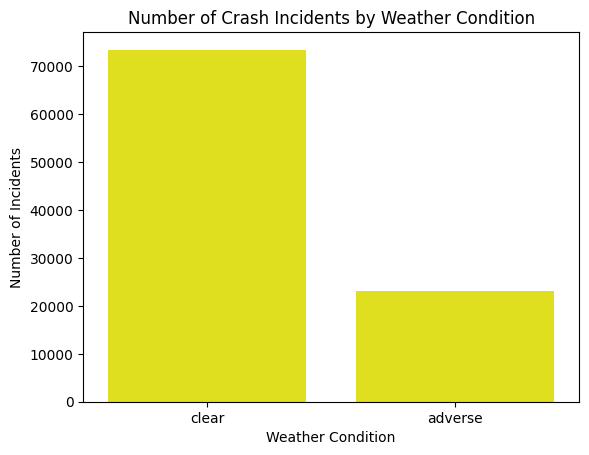

In [ ]:
incident_counts = df_test2['Weather_Condition'].value_counts()
sns.barplot(x=incident_counts.index, y=incident_counts.values, color = 'yellow')
plt.title('Number of Crash Incidents by Weather Condition')
plt.ylabel('Number of Incidents')
plt.xlabel('Weather Condition')
plt.show()

# **3.   Hypothesis: Time of Day and Crash Frequency**






⁠*Null Hypothesis (H0)*: The time of day (daytime vs. nighttime) does not significantly affect the frequency of crash incidents.

⁠*Alternative Hypothesis (H1)*: There is a significant difference in the frequency of crash incidents between daytime and nighttime.

⁠*Test to Use*: This hypothesis can be tested using a chi-square test if we're comparing the count of incidents during daytime vs. nighttime.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def categorize_time_of_day(time):
    if 6 <= time.hour < 18:
        return 'Day'
    else:
        return 'Night'

def hypothesis_testing(df):
    df = df.copy()

    df['Crash Date/Time'] = pd.to_datetime(df['Crash Date/Time'])

    df['Time of Day'] = df['Crash Date/Time'].apply(lambda x: categorize_time_of_day(x))

    contingency_table = pd.crosstab(df['Time of Day'], df['Report Number'])

    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

    print("Chi-square statistic:", chi2_stat)
    print("P-value:", p_val)
    alpha = 0.05
    if p_val is not None:
        if p_val < alpha:
            print("Reject the null hypothesis. The proportion of hit-and-run incidents is significantly different between daylight and dark conditions.")
        else:
            print("Fail to reject the null hypothesis. There is not enough evidence to conclude that the proportion of hit-and-run incidents is significantly different between daylight and dark conditions.")
    else:
        print("Unable to perform the hypothesis test due to insufficient data.")

    print("\n")

hypothesis_testing(filtered_df)

Chi-square statistic: 97457.99999999999
P-value: 0.4984939641401311
Fail to reject the null hypothesis. There is not enough evidence to conclude that the proportion of hit-and-run incidents is significantly different between daylight and dark conditions.




# **Graph**

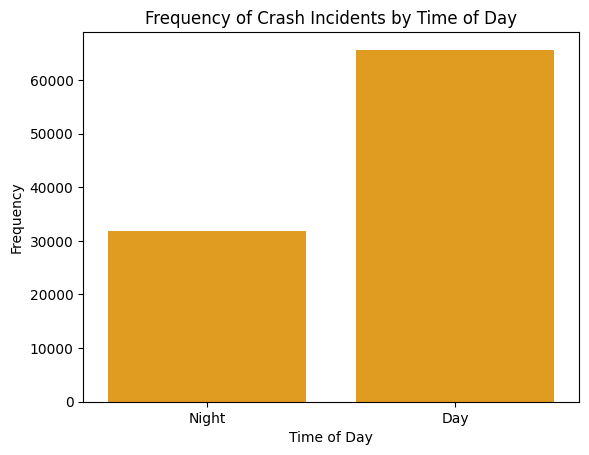

In [ ]:
def make_graph(df):
    sns.countplot(data=df, x='Time of Day', color = 'orange')
    plt.title('Frequency of Crash Incidents by Time of Day')
    plt.xlabel('Time of Day')
    plt.ylabel('Frequency')
    plt.show()

make_graph(filtered_df)

### **Conclusion**



1.   With a p-value of approximately 0.498, which is greater than the typical significance level of 0.05, we fail to reject the null hypothesis.
2.   There is insufficient evidence to suggest that the time of day (daytime vs. nighttime) significantly affects the frequency of crash incidents. Therefore, we do not have statistically significant support for the alternative hypothesis. It appears that there is no significant difference in the frequency of crash incidents between daytime and nighttime based on the available data.







--------------------------------------------------------------------------------

### **ML Algorithm Design/Development**

### **ML Algorithm Training and Test Data Analysis**

 # **Machine Learning Analysis**

--------------------------------------------------------------------------------

 # **Post Result Analysis**

### **Visualization**

### **Result**

--------------------------------------------------------------------------------

### **Conclusion**